# Compare different hydrological set-ups
All model runs were run with free-draining conditions and conditions that allowed higher groundwater tables. Eventually the parameters of the two set-ups were also switched in order to check the influence of the hydrological set-up on the fluxes. 


## Ensemble years
Ensemble years were calculated for the free-draining and dynamic water-tables set-up, for each value of the cost factor for water transport cpcff.

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta, date
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from scipy.misc import imread
import matplotlib.cbook as cbook

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


No handles with labels found to put in legend.


not found


No handles with labels found to put in legend.


not found


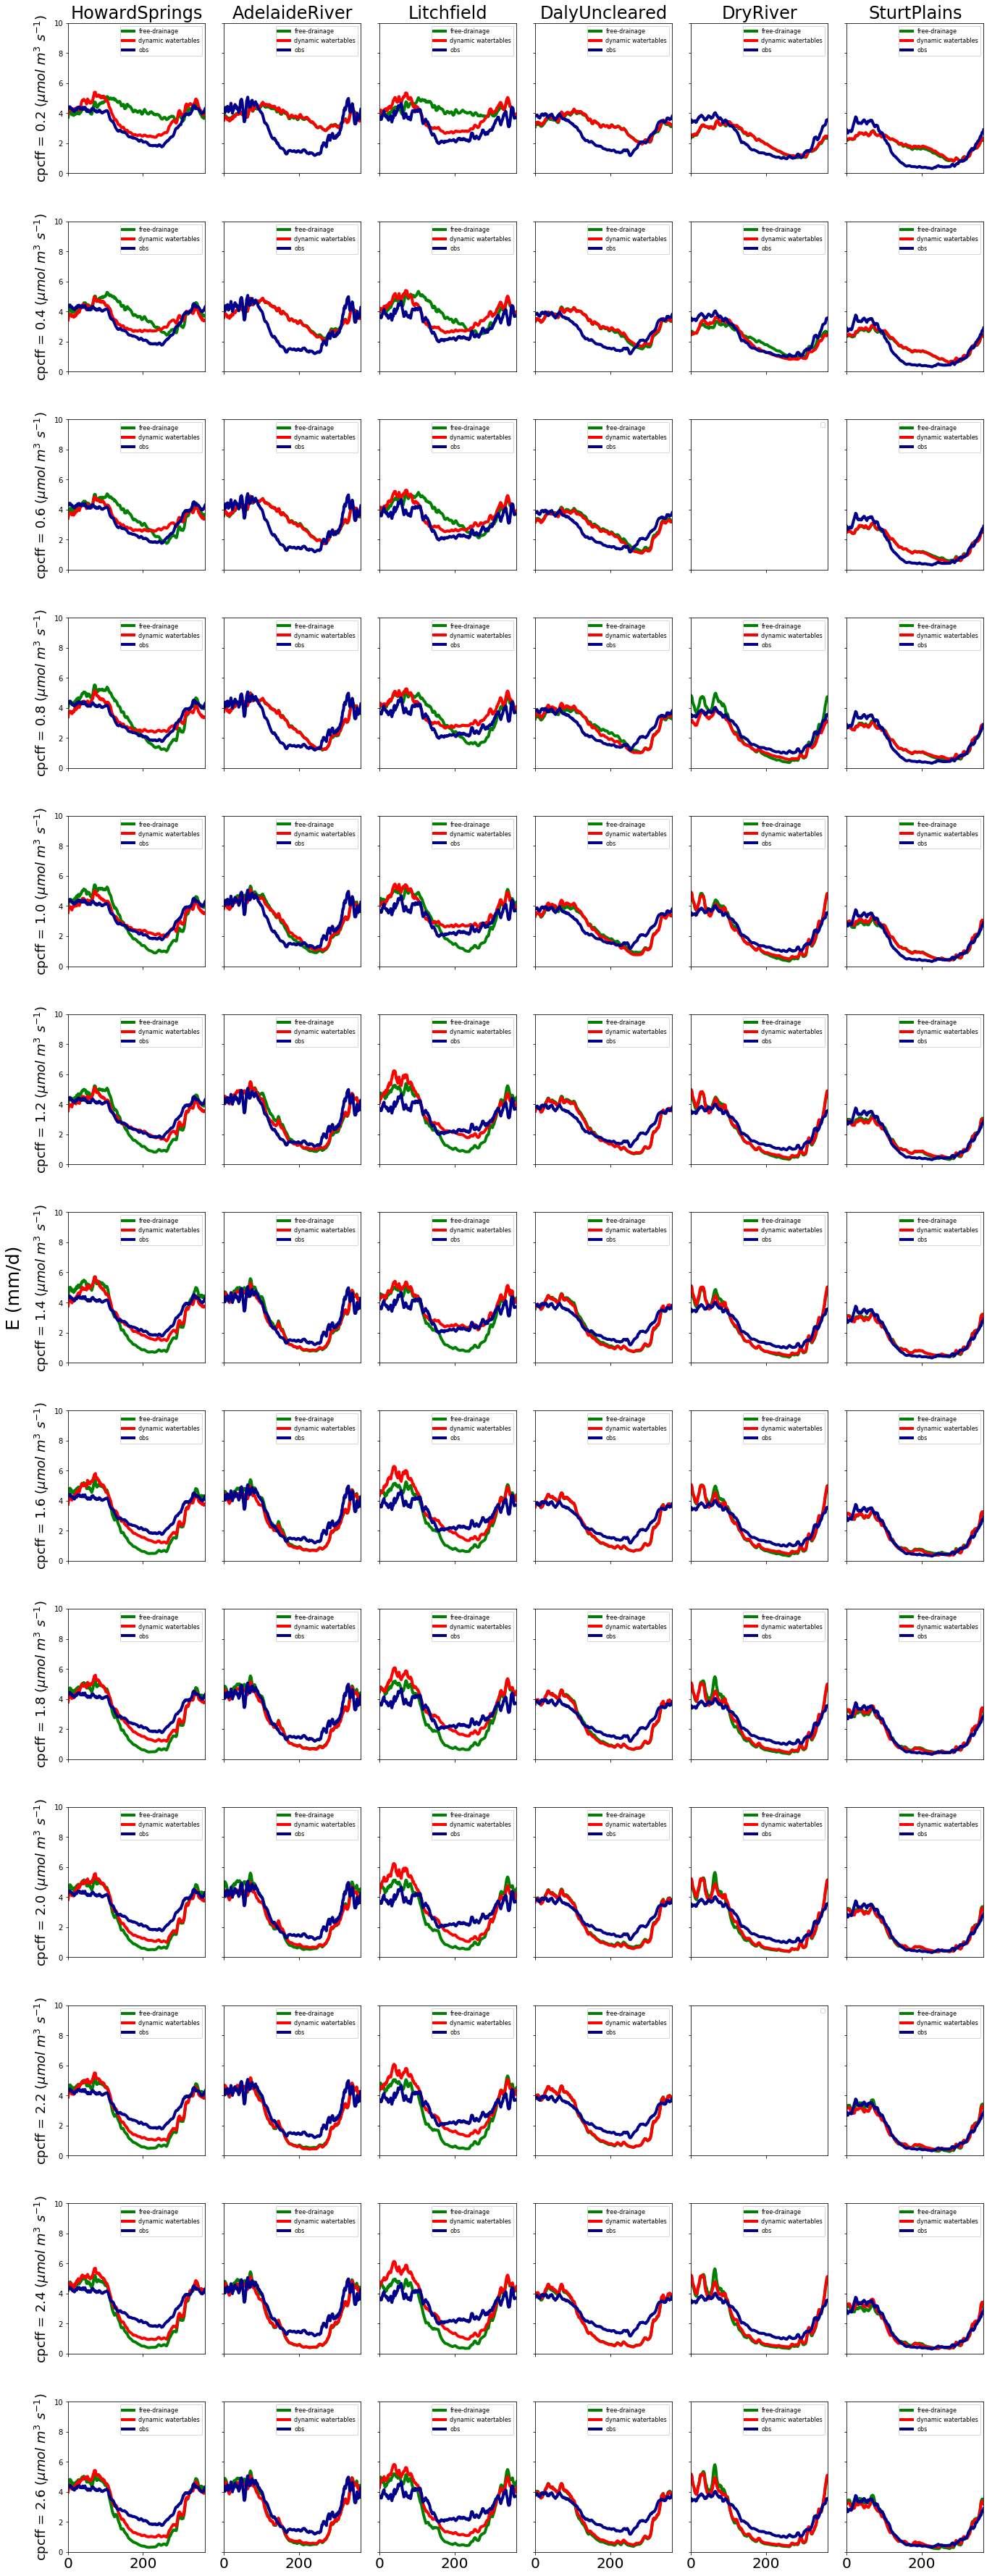

In [2]:
#ensemble year

i_site = 0
basin = ["HowardSprings", "AdelaideRiver", "Litchfield", "DalyUncleared", "DryRiver",  "SturtPlains"]
basin_short = ["howard","adelaide","litch", "daly",  "dry",  "sturt"]


cpcff_vals = np.arange(0.2,2.8, 0.2)
cpcff_str = map(str, np.round(cpcff_vals,1) ) 
cpcff_str = list(cpcff_str)


plt.rcParams['xtick.labelsize'] = 20
fig, ax   = plt.subplots(nrows=13, ncols=6, figsize=(20, 50), sharex=True, sharey=True ) 

icol = 0
irow = 0

for ibasin in  np.arange(0,6):  
    
    #load fluxtower observations
    ea_tmp = np.loadtxt("../../data/DINGO/Ea_"+ basin_short[ibasin] +".txt", usecols=2) #mm/d
    tobs =  np.genfromtxt("../../data/DINGO/Ea_"+ basin_short[ibasin] +".txt",usecols=0, dtype=np.str )#mm/d
    tobs= pd.date_range(tobs[0], tobs[-1], freq='D')
    
    DOY = tobs.dayofyear
    eo_ens = np.zeros([366])
    
    #calculate ensemble for fluxtowers
    for iday in range(0,366):
        eo_ens[iday] = np.mean( ea_tmp[DOY == (iday+1)]  )  #mm/d
       
    #loop over cpcff-values
    for cpcff in cpcff_str:

        try:
            #load data free-draining conditions
            inputfile = "../../data/VOM_output/"+ basin[ibasin] + "/freedrainage_cpcff" + cpcff + "/sce_best/results_daily.txt"  
            data1 = np.genfromtxt(inputfile, names=True)

            #load data dynamic watertables
            inputfile = "../../data/VOM_output/" + basin[ibasin] + "/nofreedrainage_cpcff" + cpcff + "/sce_best/results_daily.txt"
            data2 = np.genfromtxt(inputfile, names=True)

            #calculate total evaporation
            e1 = data1["esoil"] + data1["etmt"] + data1["etmg"]
            e2 = data2["esoil"] + data2["etmt"] + data2["etmg"]

            #define timeseries
            tmod1 = pd.date_range( data1["fyear"][0] + data1["fmonth"][0]  + data1["fday"][0], freq = "D", periods = len(e1))
            tmod2 = pd.date_range( data2["fyear"][0] + data2["fmonth"][0]  + data1["fday"][0], freq = "D", periods = len(e2))


            #empty arrays for ensemble years
            e_ens1 = np.zeros([366])
            e_ens2 = np.zeros([366])
            e7d1 = np.zeros([367])
            e7d2 = np.zeros([367])
            eo7d = np.zeros([367]) #observed

            #use last 10 years for ensembles
            tmp1 = e1[-3650:]
            tmp2 = e2[-3650:]

            DOY = tmod1.dayofyear[0:len(tmp1)] 
            DOY = DOY[-3650:]
            for iday in range(0,366):
                e_ens1[iday] = np.mean( tmp1[DOY == (iday+1)]  ) * 1000 #mm/d
                e_ens2[iday] = np.mean( tmp2[DOY == (iday+1)]  ) * 1000 #mm/d

            #7-day running mean
            N = 7
            for iday in range(0,367):
                if iday > (366-N):
                    e7d1[iday]  = np.mean( np.concatenate( (e_ens1[iday:366], e_ens1[0:(N-(366-iday))] )) )
                    e7d2[iday]  = np.mean( np.concatenate( (e_ens2[iday:366], e_ens2[0:(N-(366-iday))] )) )
                    eo7d[iday]  = np.mean( np.concatenate( (eo_ens[iday:366], eo_ens[0:(N-(366-iday))] )) )
                else:    
                    e7d1[iday] = np.mean(e_ens1[iday:(iday+N)])
                    e7d2[iday] = np.mean(e_ens2[iday:(iday+N)])
                    eo7d[iday] = np.mean(eo_ens[iday:(iday+N)])

            ax[irow, icol].plot(range(0,367), e7d1, color = "green", linewidth=4, label = "free-drainage")
            ax[irow, icol].plot(range(0,367), e7d2, color="red", linewidth=4, label="dynamic watertables")
            ax[irow, icol].plot(range(0,367), eo7d, color="darkblue", linewidth=4, label = "obs")
        except OSError:
            print("not found")
            
        #ax0.set(ylabel = r'Residuals Et ( $\sigma_{ET} $  )', xlabel = '' )
        #ax0.set_xlim([datetime(year[ibasin],1, 1), datetime( year[ibasin] ,12, 31)])  
        ax[irow, icol].set_ylim([ 0, 10 ])
        ax[irow, icol].set_xlim([ 0, 366 ])  

        
        if(irow == 0):
            ax[irow, icol].set_title(basin[ibasin], fontsize = 24)
        
        #ax[irow, icol].set_xlabel('DOY' , size=18   )
    
        #for tick in ax[irow, icol].xaxis.get_major_ticks():
        #    tick.label.set_fontsize(24)
        #for tick in ax[irow, icol].yaxis.get_major_ticks():
        #    tick.label.set_fontsize(24)

        ax[irow, icol].legend(prop={'size':8})
        if(icol == 0):
            ax[irow, icol].set_ylabel( r'cpcff = ' + cpcff  +' ($\mu$$mol$ $m^3$ $s^{-1}$)', fontsize=18)
        irow = irow + 1
    

        
    icol = icol + 1
    irow = 0 
    
    
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("E (mm/d)", size = 25, labelpad=40)

plt.tight_layout()
plt.show()



## Groundwater tables


### Free-draining conditions

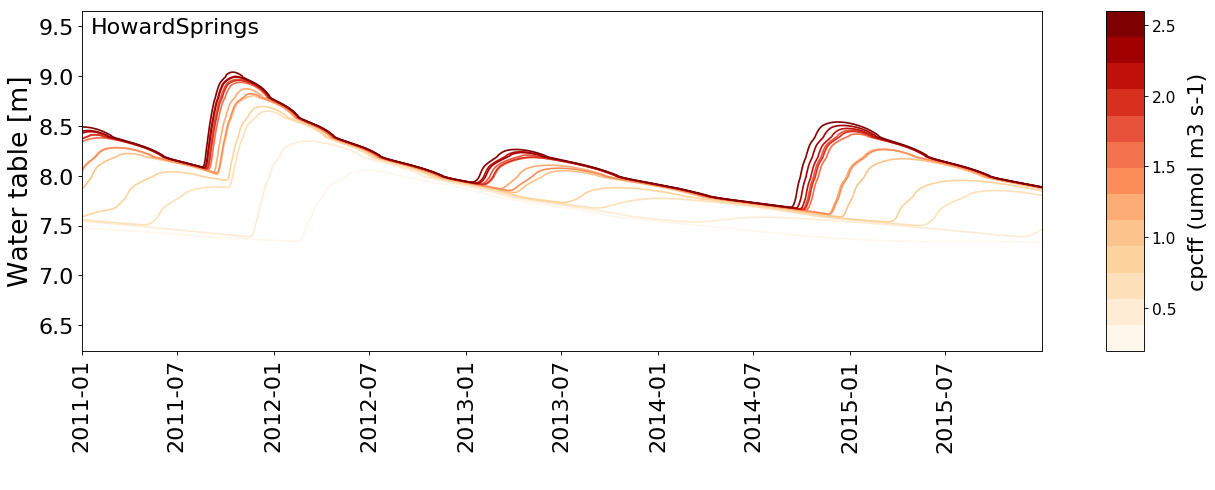

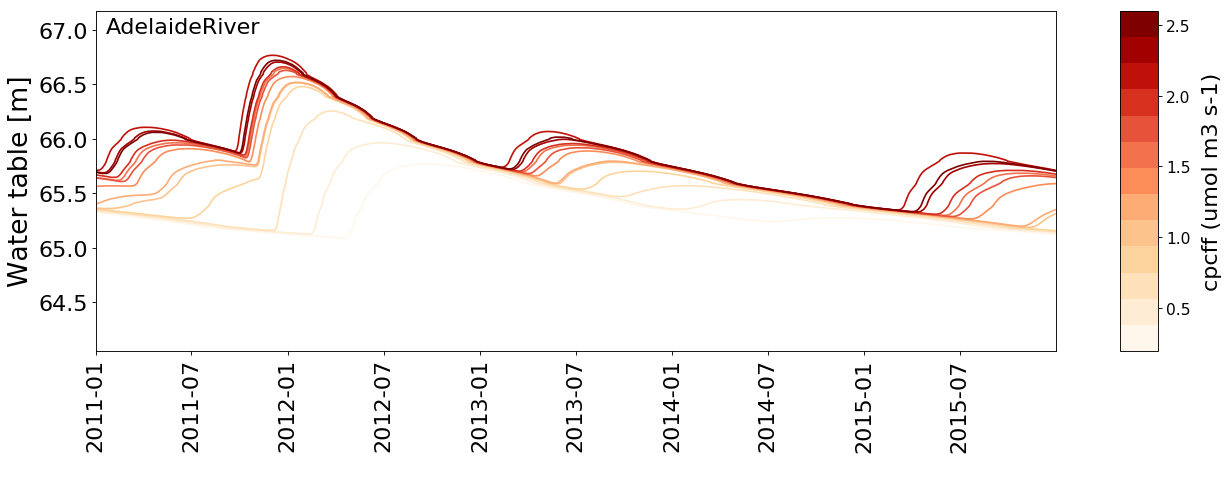

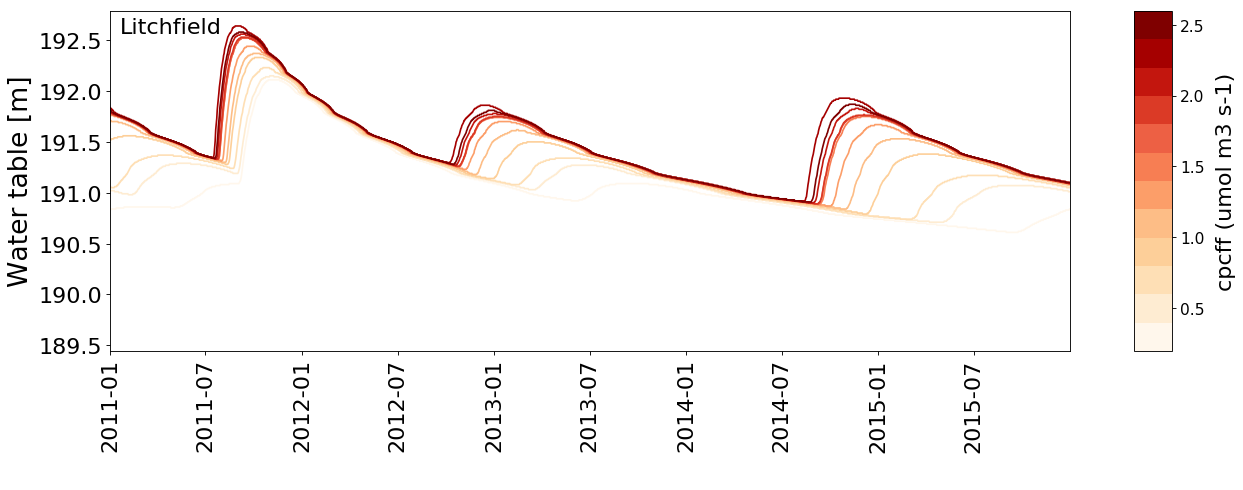

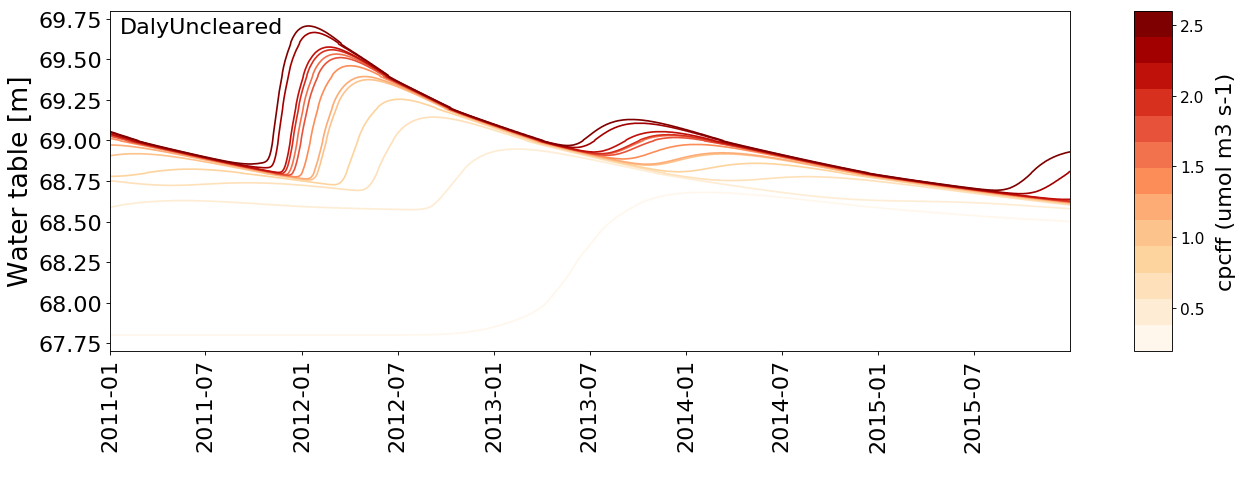

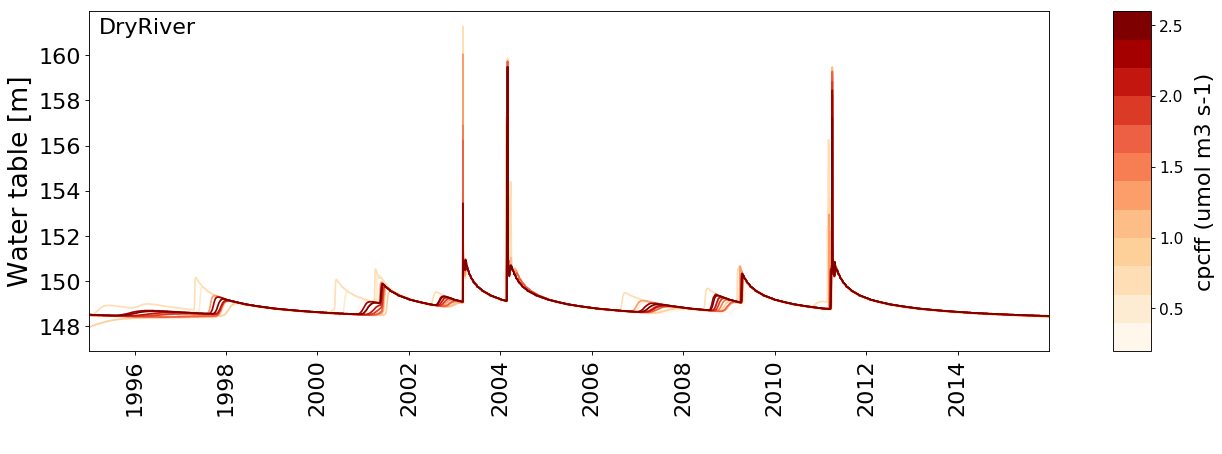

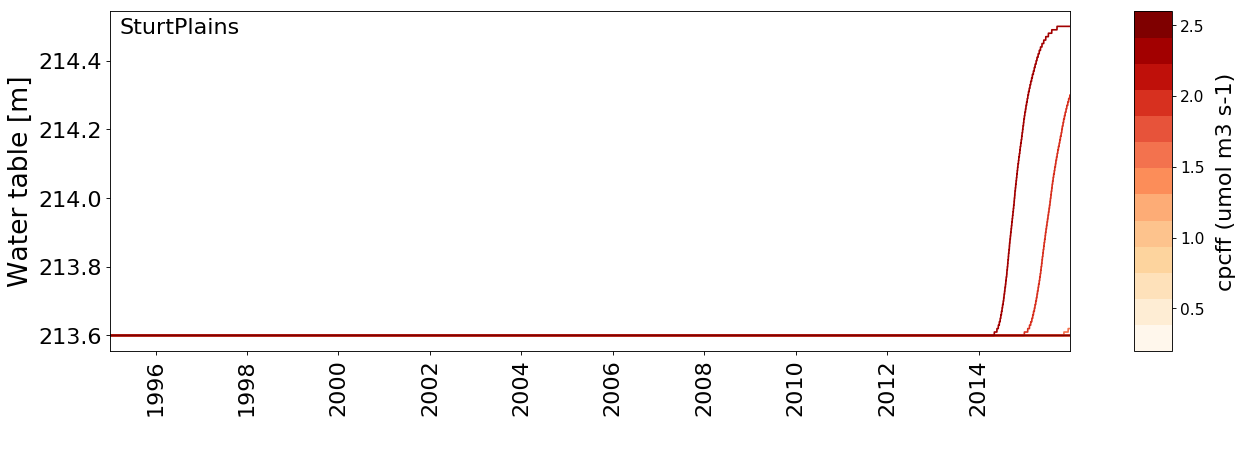

In [10]:
#HowardSprings
%run ../../src_py/plot_et_ass.py  \
-i ../../data/VOM_output/HowardSprings/freedrainage_cpcff0.2/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/freedrainage_cpcff0.4/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/freedrainage_cpcff0.6/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/freedrainage_cpcff0.8/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/freedrainage_cpcff1.0/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/freedrainage_cpcff1.2/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/freedrainage_cpcff1.4/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/freedrainage_cpcff1.6/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/freedrainage_cpcff1.8/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/freedrainage_cpcff2.0/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/freedrainage_cpcff2.2/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/freedrainage_cpcff2.4/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/freedrainage_cpcff2.6/sce_best/results_daily.txt \
-v zw -ys 2011 -ye 2015 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--ylabel "Water table [m]"  \
--plot_cbar True --cblabel "cpcff (umol m3 s-1)" --labels VOM VOM2 \
--title "HowardSprings"

#AdelaideRiver
%run ../../src_py/plot_et_ass.py  \
-i ../../data/VOM_output/AdelaideRiver/freedrainage_cpcff0.2/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/freedrainage_cpcff0.4/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/freedrainage_cpcff0.6/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/freedrainage_cpcff0.8/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.0/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.2/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.4/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.6/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/freedrainage_cpcff1.8/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/freedrainage_cpcff2.0/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/freedrainage_cpcff2.2/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/freedrainage_cpcff2.4/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/freedrainage_cpcff2.6/sce_best/results_daily.txt \
-v zw -ys 2011 -ye 2015 -w ../../data/VOM_input/AdelaideRiver/dailyweather.prn \
--ylabel "Water table [m]"  \
--plot_cbar True --cblabel "cpcff (umol m3 s-1)" --labels VOM VOM2 \
--title "AdelaideRiver"

#Litchfield
%run ../../src_py/plot_et_ass.py  \
-i ../../data/VOM_output/Litchfield/freedrainage_cpcff0.2/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/freedrainage_cpcff0.4/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/freedrainage_cpcff0.6/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/freedrainage_cpcff0.8/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/freedrainage_cpcff1.0/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/freedrainage_cpcff1.2/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/freedrainage_cpcff1.4/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/freedrainage_cpcff1.6/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/freedrainage_cpcff1.8/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/freedrainage_cpcff2.0/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/freedrainage_cpcff2.4/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/freedrainage_cpcff2.6/sce_best/results_daily.txt \
-v zw -ys 2011 -ye 2015 -w ../../data/VOM_input/Litchfield/dailyweather.prn \
--ylabel "Water table [m]"  \
--plot_cbar True --cblabel "cpcff (umol m3 s-1)" --labels VOM VOM2 \
--title "Litchfield"

#DalyUncleared
%run ../../src_py/plot_et_ass.py  \
-i ../../data/VOM_output/DalyUncleared/freedrainage_cpcff0.2/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/freedrainage_cpcff0.4/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/freedrainage_cpcff0.6/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/freedrainage_cpcff0.8/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/freedrainage_cpcff1.0/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/freedrainage_cpcff1.2/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/freedrainage_cpcff1.4/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/freedrainage_cpcff1.6/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/freedrainage_cpcff1.8/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/freedrainage_cpcff2.0/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/freedrainage_cpcff2.2/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/freedrainage_cpcff2.4/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/freedrainage_cpcff2.6/sce_best/results_daily.txt \
-v zw -ys 2011 -ye 2015 -w ../../data/VOM_input/DalyUncleared/dailyweather.prn \
--ylabel "Water table [m]"  \
--plot_cbar True --cblabel "cpcff (umol m3 s-1)" --labels VOM VOM2 \
--title "DalyUncleared"

#DryRiver
%run ../../src_py/plot_et_ass.py  \
-i ../../data/VOM_output/DryRiver/freedrainage_cpcff0.2/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/freedrainage_cpcff0.4/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/freedrainage_cpcff0.6/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/freedrainage_cpcff0.8/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/freedrainage_cpcff1.0/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/freedrainage_cpcff1.2/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/freedrainage_cpcff1.4/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/freedrainage_cpcff1.6/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/freedrainage_cpcff1.8/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/freedrainage_cpcff2.0/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/freedrainage_cpcff2.4/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/freedrainage_cpcff2.6/sce_best/results_daily.txt \
-v zw -ys 1995 -ye 2015 -w ../../data/VOM_input/DryRiver/dailyweather.prn \
--ylabel "Water table [m]"  \
--plot_cbar True --cblabel "cpcff (umol m3 s-1)" --labels VOM VOM2 \
--title "DryRiver"

#SturtPlains
%run ../../src_py/plot_et_ass.py  \
-i ../../data/VOM_output/SturtPlains/freedrainage_cpcff0.2/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/freedrainage_cpcff0.4/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/freedrainage_cpcff0.6/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/freedrainage_cpcff0.8/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/freedrainage_cpcff1.0/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/freedrainage_cpcff1.2/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/freedrainage_cpcff1.4/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/freedrainage_cpcff1.6/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/freedrainage_cpcff1.8/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/freedrainage_cpcff2.0/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/freedrainage_cpcff2.2/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/freedrainage_cpcff2.4/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/freedrainage_cpcff2.6/sce_best/results_daily.txt \
-v zw -ys 1995 -ye 2015 -w ../../data/VOM_input/SturtPlains/dailyweather.prn \
--ylabel "Water table [m]"  \
--plot_cbar True --cblabel "cpcff (umol m3 s-1)" --labels VOM VOM2 \
--title "SturtPlains"


### Dynamic watertables

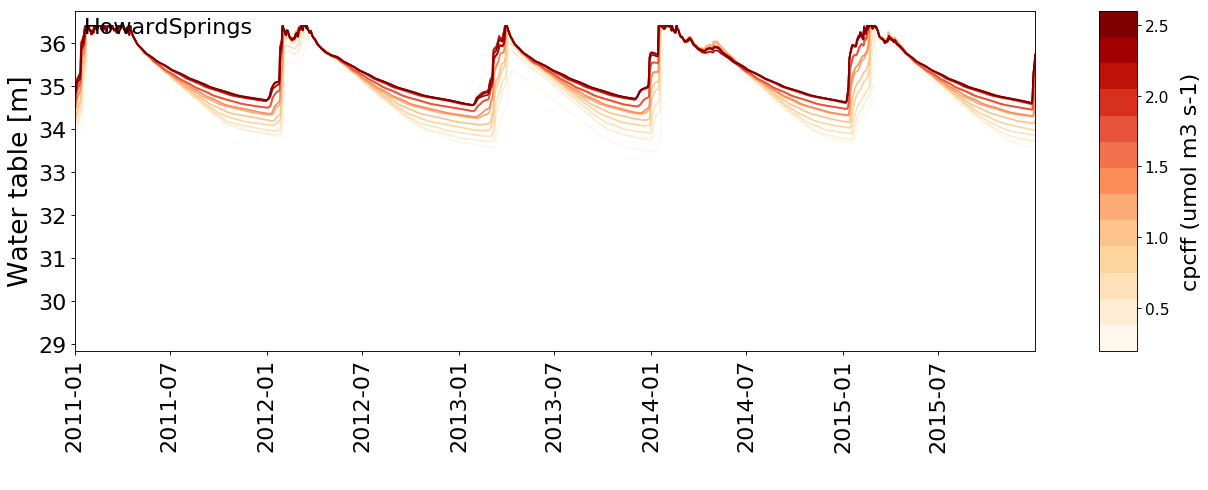

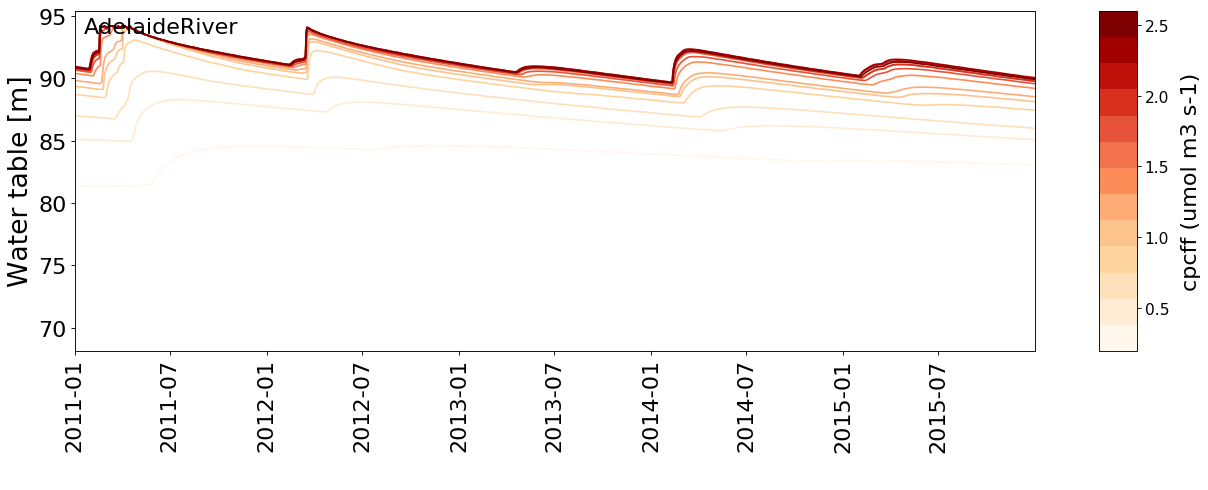

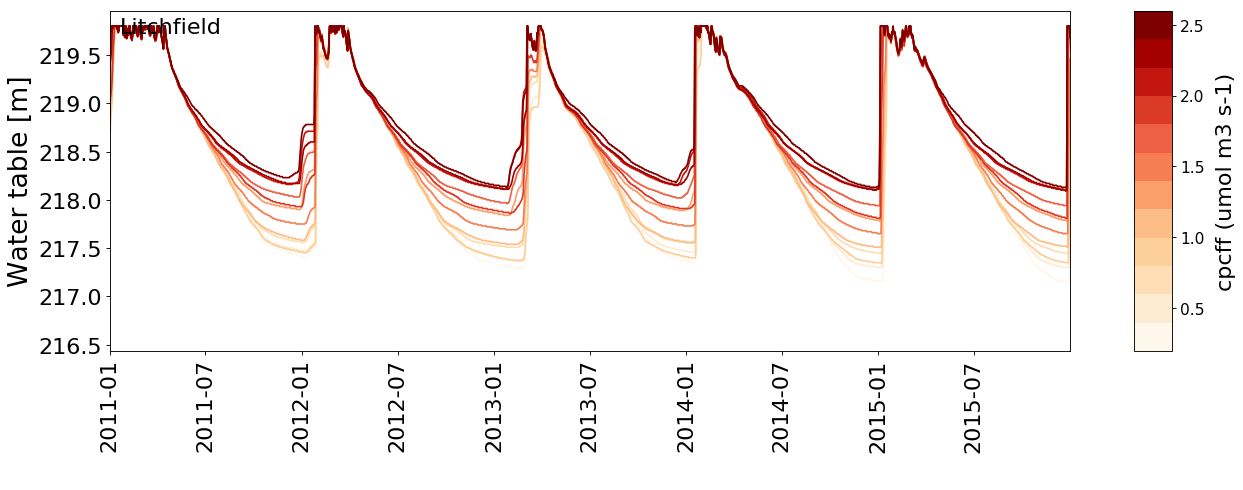

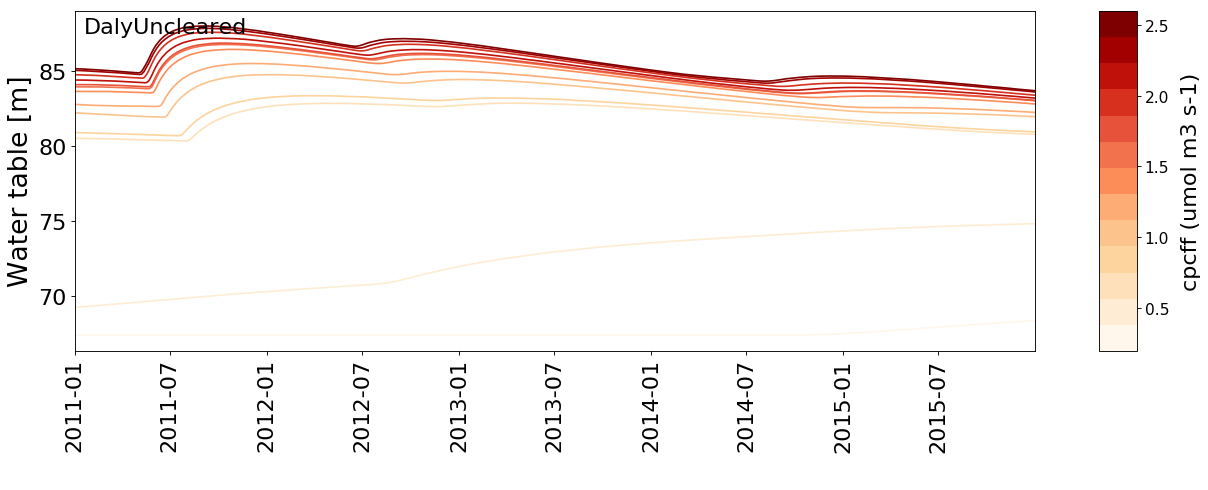

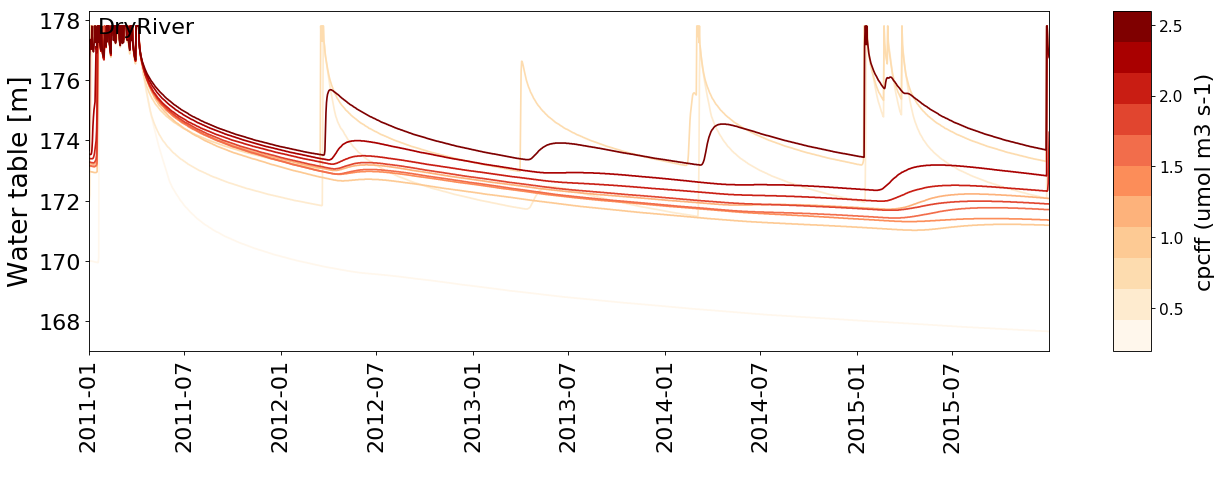

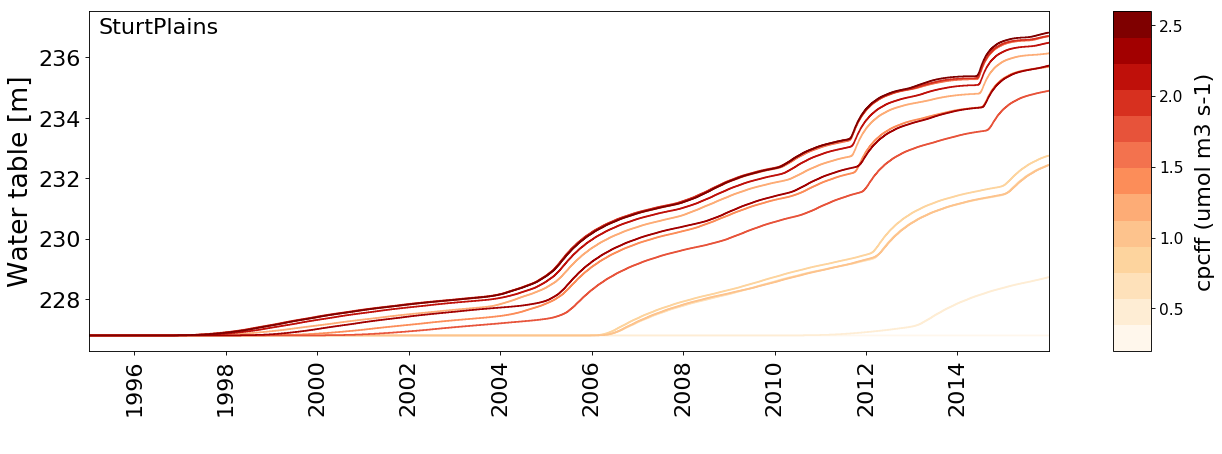

In [8]:
#HowardSprings
%run ../../src_py/plot_et_ass.py  \
-i ../../data/VOM_output/HowardSprings/nofreedrainage_cpcff0.2/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/nofreedrainage_cpcff0.4/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/nofreedrainage_cpcff0.6/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/nofreedrainage_cpcff0.8/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/nofreedrainage_cpcff1.0/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/nofreedrainage_cpcff1.2/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/nofreedrainage_cpcff1.4/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/nofreedrainage_cpcff1.6/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/nofreedrainage_cpcff1.8/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/nofreedrainage_cpcff2.0/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/nofreedrainage_cpcff2.2/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/nofreedrainage_cpcff2.4/sce_best/results_daily.txt \
../../data/VOM_output/HowardSprings/nofreedrainage_cpcff2.6/sce_best/results_daily.txt \
-v zw -ys 2011 -ye 2015 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--ylabel "Water table [m]"  \
--plot_cbar True --cblabel "cpcff (umol m3 s-1)" --labels VOM VOM2 \
--title "HowardSprings"

#AdelaideRiver
%run ../../src_py/plot_et_ass.py  \
-i ../../data/VOM_output/AdelaideRiver/nofreedrainage_cpcff0.2/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/nofreedrainage_cpcff0.4/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/nofreedrainage_cpcff0.6/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/nofreedrainage_cpcff0.8/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/nofreedrainage_cpcff1.0/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/nofreedrainage_cpcff1.2/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/nofreedrainage_cpcff1.4/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/nofreedrainage_cpcff1.6/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/nofreedrainage_cpcff1.8/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/nofreedrainage_cpcff2.0/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/nofreedrainage_cpcff2.2/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/nofreedrainage_cpcff2.4/sce_best/results_daily.txt \
../../data/VOM_output/AdelaideRiver/nofreedrainage_cpcff2.6/sce_best/results_daily.txt \
-v zw -ys 2011 -ye 2015 -w ../../data/VOM_input/AdelaideRiver/dailyweather.prn \
--ylabel "Water table [m]"  \
--plot_cbar True --cblabel "cpcff (umol m3 s-1)" --labels VOM VOM2 \
--title "AdelaideRiver"

#Litchfield
%run ../../src_py/plot_et_ass.py  \
-i ../../data/VOM_output/Litchfield/nofreedrainage_cpcff0.2/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/nofreedrainage_cpcff0.4/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/nofreedrainage_cpcff0.6/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/nofreedrainage_cpcff0.8/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/nofreedrainage_cpcff1.0/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/nofreedrainage_cpcff1.2/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/nofreedrainage_cpcff1.4/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/nofreedrainage_cpcff1.6/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/nofreedrainage_cpcff1.8/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/nofreedrainage_cpcff2.0/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/nofreedrainage_cpcff2.4/sce_best/results_daily.txt \
../../data/VOM_output/Litchfield/nofreedrainage_cpcff2.6/sce_best/results_daily.txt \
-v zw -ys 2011 -ye 2015 -w ../../data/VOM_input/Litchfield/dailyweather.prn \
--ylabel "Water table [m]"  \
--plot_cbar True --cblabel "cpcff (umol m3 s-1)" --labels VOM VOM2 \
--title "Litchfield"

#DalyUncleared
%run ../../src_py/plot_et_ass.py  \
-i ../../data/VOM_output/DalyUncleared/nofreedrainage_cpcff0.2/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/nofreedrainage_cpcff0.4/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/nofreedrainage_cpcff0.6/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/nofreedrainage_cpcff0.8/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/nofreedrainage_cpcff1.0/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/nofreedrainage_cpcff1.2/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/nofreedrainage_cpcff1.4/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/nofreedrainage_cpcff1.6/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/nofreedrainage_cpcff1.8/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/nofreedrainage_cpcff2.0/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/nofreedrainage_cpcff2.2/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/nofreedrainage_cpcff2.4/sce_best/results_daily.txt \
../../data/VOM_output/DalyUncleared/nofreedrainage_cpcff2.6/sce_best/results_daily.txt \
-v zw -ys 2011 -ye 2015 -w ../../data/VOM_input/DalyUncleared/dailyweather.prn \
--ylabel "Water table [m]"  \
--plot_cbar True --cblabel "cpcff (umol m3 s-1)" --labels VOM VOM2 \
--title "DalyUncleared"

#DryRiver
%run ../../src_py/plot_et_ass.py  \
-i ../../data/VOM_output/DryRiver/nofreedrainage_cpcff0.2/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/nofreedrainage_cpcff0.4/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/nofreedrainage_cpcff0.8/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/nofreedrainage_cpcff1.0/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/nofreedrainage_cpcff1.2/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/nofreedrainage_cpcff1.4/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/nofreedrainage_cpcff1.6/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/nofreedrainage_cpcff1.8/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/nofreedrainage_cpcff2.0/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/nofreedrainage_cpcff2.4/sce_best/results_daily.txt \
../../data/VOM_output/DryRiver/nofreedrainage_cpcff2.6/sce_best/results_daily.txt \
-v zw -ys 2011 -ye 2015 -w ../../data/VOM_input/DryRiver/dailyweather.prn \
--ylabel "Water table [m]"  \
--plot_cbar True --cblabel "cpcff (umol m3 s-1)" --labels VOM VOM2 \
--title "DryRiver"

#SturtPlains
%run ../../src_py/plot_et_ass.py  \
-i ../../data/VOM_output/SturtPlains/nofreedrainage_cpcff0.2/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/nofreedrainage_cpcff0.4/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/nofreedrainage_cpcff0.6/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/nofreedrainage_cpcff0.8/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/nofreedrainage_cpcff1.0/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/nofreedrainage_cpcff1.2/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/nofreedrainage_cpcff1.4/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/nofreedrainage_cpcff1.6/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/nofreedrainage_cpcff1.8/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/nofreedrainage_cpcff2.0/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/nofreedrainage_cpcff2.2/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/nofreedrainage_cpcff2.4/sce_best/results_daily.txt \
../../data/VOM_output/SturtPlains/nofreedrainage_cpcff2.6/sce_best/results_daily.txt \
-v zw -ys 1995 -ye 2015 -w ../../data/VOM_input/SturtPlains/dailyweather.prn \
--ylabel "Water table [m]"  \
--plot_cbar True --cblabel "cpcff (umol m3 s-1)" --labels VOM VOM2 \
--title "SturtPlains"
